# TF跑CNN原則：請把矩陣大小和格式輸入輸出對清楚

In [10]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name ='W')

def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name ='b')

def conv2d(x, W): #由strides第2,3維度決定filter一次往x和y方向走動多少
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], #濾鏡大小 
                          strides=[1,2,2,1], #2x2中取最大
                          padding='SAME')

#輸入層
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float",shape=[None, 784], name="X")    
    x_image = tf.reshape(x, [-1, 28, 28, 1]) #為了符合卷基第一層的格式，第四個維度是RGB:3，黑白:1

#卷積1
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,1,16])
    b1 = bias([16])
    C1_Conv = tf.nn.relu( conv2d(x_image, W1) + b1 )
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)
    
#卷積2
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    C2_Conv = tf.nn.relu( conv2d(C1_Pool, W2) + b2 )
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)
    

#Fully connected layer
with tf.name_scope('D_Flat'): #壓成平的
    D_Flat = tf.reshape(C2_Pool, [-1, 1764])
    
with tf.name_scope('D_Hidden_Layer'):
    W3= weight([1764, 32])
    b3= bias([32])
    D_Hidden = tf.nn.relu( tf.matmul(D_Flat, W3) + b3 )
    D_Hidden_Dropout= tf.nn.dropout(D_Hidden, keep_prob=0.8)
    
with tf.name_scope('Output_Layer'):
    W4 = weight([32,10])
    b4 = bias([10])
    y_predict= tf.nn.softmax( tf.matmul(D_Hidden_Dropout, W4) + b4 )
    

#設置optimizer
with tf.name_scope("optimizer"):
    
    y_label = tf.placeholder("float", shape=[None, 10], name="y_label") #在這裡才引入標準解答y_label
    
    loss_function = tf.reduce_mean(
                      tf.nn.softmax_cross_entropy_with_logits
                         (logits=y_predict , 
                          labels=y_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)
    
#評估模型
with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1),
                                  tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
#訓練模型
trainEpochs = 10
batchSize = 100
totalBatchs = int(mnist.train.num_examples/batchSize)

epoch_list=[]
accuracy_list=[]
loss_list=[]

from time import time
startTime=time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(trainEpochs):

    
    for i in range(totalBatchs):
        batch_x, batch_y = mnist.train.next_batch(batchSize)
        sess.run(optimizer,feed_dict={x: batch_x,
                                      y_label: batch_y})
        
    
    loss,acc = sess.run([loss_function,accuracy],
                        feed_dict={x: mnist.validation.images, 
                                   y_label: mnist.validation.labels})

    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)    
    
    print("Train Epoch:", '%02d' % (epoch+1), \
          "Loss=","{:.9f}".format(loss)," Accuracy=",acc, 'Epoch time=',time()-startTime)
    
duration = time()-startTime
print("Train Finished takes:",duration)     

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Train Epoch: 01 Loss= 1.772440672  Accuracy= 0.726 Epoch time= 195.74426317214966
Train Epoch: 02 Loss= 1.682628512  Accuracy= 0.7956 Epoch time= 366.751825094223
Train Epoch: 03 Loss= 1.653133631  Accuracy= 0.8208 Epoch time= 528.5873410701752
Train Epoch: 04 Loss= 1.635702729  Accuracy= 0.8328 Epoch time= 706.1330091953278
Train Epoch: 05 Loss= 1.545454741  Accuracy= 0.9282 Epoch time= 896.8710191249847
Train Epoch: 06 Loss= 1.532291651  Accuracy= 0.9358 Epoch time= 1062.438371181488
Train Epoch: 07 Loss= 1.523599267  Accuracy= 0.9442 Epoch time= 1223.706612110138
Train Epoch: 08 Loss= 1.516631484  Accuracy= 0.9524 Epoch time= 1383.760931968689
Train Epoch: 09 Loss= 1.511740208  Accuracy= 0.955 Epoch time= 1544.0960071086884
Train Epoch: 10 Loss= 1.505177498  Accuracy= 0.9616 Epoch time= 1997.

## loss, accu視覺化 

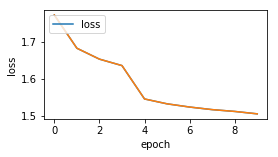

In [12]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

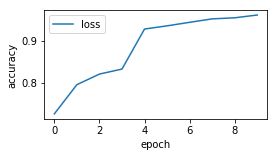

In [13]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, accuracy_list, label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [14]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: mnist.test.images,
                                   y_label: mnist.test.labels}))

Accuracy: 0.956


# 實際預測

In [15]:
y_predict = sess.run(y_predict, 
                     feed_dict={x: mnist.test.images[:5000]})

In [16]:
prediction_result=sess.run(tf.argmax(y_predict,1),
                           feed_dict={x: mnist.test.images ,
                                      y_label: mnist.test.labels})

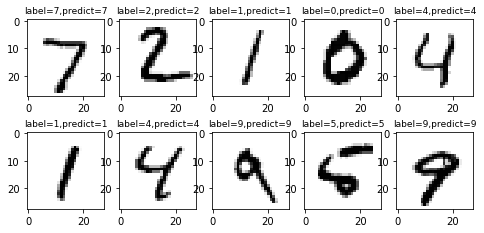

In [17]:
import numpy as np
def show_images_labels_predict(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    for i in range(0, 10):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(np.reshape(images[i],(28, 28)), cmap='binary')
        ax.set_title("label=" +str(np.argmax(labels[i]))+
                     ",predict="+str(prediction_result[i])
                     ,fontsize=9) 
    plt.show()

show_images_labels_predict(mnist.test.images,mnist.test.labels,prediction_result)

找尋錯誤的配對

In [18]:
for i in range(500):
    if prediction_result[i]!=np.argmax(mnist.test.labels[i]):
        print("i="+str(i)+
              "   label=",np.argmax(mnist.test.labels[i]),
              "predict=",prediction_result[i])

i=33   label= 4 predict= 6
i=119   label= 2 predict= 9
i=121   label= 4 predict= 9
i=193   label= 9 predict= 3
i=259   label= 6 predict= 0
i=290   label= 8 predict= 4
i=317   label= 5 predict= 8
i=320   label= 9 predict= 1
i=321   label= 2 predict= 7
i=340   label= 5 predict= 3
i=349   label= 3 predict= 7
i=353   label= 6 predict= 0
i=362   label= 2 predict= 7
i=435   label= 8 predict= 7
i=444   label= 2 predict= 8
i=445   label= 6 predict= 0
i=448   label= 9 predict= 8
i=464   label= 3 predict= 7
i=469   label= 5 predict= 8
i=479   label= 9 predict= 3
i=495   label= 8 predict= 2


# 跑了這麼久，儲存model

In [19]:
saver = tf.train.Saver()

In [20]:
save_path = saver.save(sess, "saveModel/CNN_model1")
print("Model saved in file: %s" % save_path)

Model saved in file: saveModel/CNN_model1


In [21]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN',sess.graph)

# 畫tensorboard